# Training an Optimized Decision Trees Model for Fraud Detection

This notebook implements the end-to-end process of training an optimized Decision Trees model. The steps and techniques are derived from the best practices identified in the "Reproducible Machine Learning for Credit Card Fraud Detection" handbook.

The process includes
1. Loading and preprocessing data to create aggregated features.
2. Creating baseline model
3. Defining a robust validation strategy.
5. Optimizing parameters and evaluating the final model using the recommended set of complementary metrics.
6. Saving the final, optimized model artifact for production use.

## 1. Loading and preprocessing data
In this section, we will implement three types of feature transformation that are known to be relevant for payment card fraud detection.

![encoding](experiment/images/encoding_variables.png)

The first type of transformation involves the date/time variable, and consists in creating binary features that characterize potentially relevant periods. We will create two such features. The first one will characterize whether a transaction occurs during a weekday or during the weekend. The second will characterize whether a transaction occurs during the day or the night. These features can be useful since it has been observed in real-world datasets that fraudulent patterns differ between weekdays and weekends, and between the day and night.  

The second type of transformation involves the customer ID and consists in creating features that characterize the customer spending behaviors. We will follow the RFM (Recency, Frequency, Monetary value) framework proposed in {cite}`VANVLASSELAER201538`, and keep track of the average spending amount and number of transactions for each customer and for three window sizes. This will lead to the creation of six new features.

The third type of transformation involves the terminal ID and consists in creating new features that characterize the 'risk' associated with the terminal. The risk will be defined as the average number of frauds that were observed on the terminal for three window sizes. This will lead to the creation of three new features. 

The table below summarizes the types of transformation that will be performed and the new features that will be created. 

|Original feature name|Original feature type|Transformation|Number of new features|New feature(s) type|
|---|---|---|---|---|
|TX\_DATE\_TIME | Panda timestamp |0 if transaction during a weekday, 1 if transaction during a weekend. The new feature is called TX_DURING_WEEKEND.|1|Integer (0/1)|
|TX\_DATE\_TIME | Panda timestamp |0 if transaction between 6am and 0pm, 1 if transaction between 0pm and 6am. The new feature is called TX_DURING_NIGHT.|1|Integer (0/1)|
|CUSTOMER\_ID | Categorical variable |Number of transactions by the customer in the last n day(s), for n in {1,7,30}. The new features are called CUSTOMER_ID_NB_TX_nDAY_WINDOW.|3|Integer|
|CUSTOMER\_ID | Categorical variable |Average spending amount in the last n day(s), for n in {1,7,30}. The new features are called CUSTOMER_ID_AVG_AMOUNT_nDAY_WINDOW.|3|Real|
|TERMINAL\_ID | Categorical variable |Number of transactions on the terminal in the last n+d day(s), for n in {1,7,30} and d=7. The parameter d is called delay and will be discussed later in this notebook. The new features are called TERMINAL_ID_NB_TX_nDAY_WINDOW.|3|Integer|
|TERMINAL\_ID | Categorical variable |Average number of frauds on the terminal in the last n+d day(s), for n in {1,7,30} and d=7. The parameter d is called delay and will be discussed later in this notebook. The new features are called TERMINAL_ID_RISK_nDAY_WINDOW.|3|Real|

The following sections provide the implementation for each of these three transformations. After the transformations, a set of 14 new features will be created. Note that some of the features are the result of aggregation functions over the values of other features or conditions (same customer, given time window). These features are often referred to as *aggregated features*.

In [2]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
%run ./experiment/shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-raw"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-raw
        
DIR_INPUT='./simulated-data-raw/data' 

BEGIN_DATE = "2018-04-01"
END_DATE = "2018-09-30"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: user 1.19 s, sys: 218 ms, total: 1.41 s
Wall time: 1.53 s
1754155 transactions loaded, containing 14681 fraudulent transactions


In [3]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


### Define the feature transformation functions

1.  **Date & Time Features**:
    * `TX_DURING_WEEKEND`: A binary feature that is `1` for weekend transactions and `0` for weekdays.
    * `TX_DURING_NIGHT`: A binary feature that is `1` for transactions between 0pm and 6am, and `0` otherwise.

2.  **Customer Spending Features**:
    * Inspired by the RFM (Recency, Frequency, Monetary) framework, the `get_customer_spending_behaviour_features` function calculates six new features.
    * It computes the transaction count and average transaction amount for each customer over rolling 1, 7, and 30-day windows.

3.  **Terminal Risk Features**:
    * The `get_count_risk_rolling_window` function extracts a "risk score" and transaction count for each terminal over 1, 7, and 30-day windows, creating six new features.
    * To account for the real-world lag in fraud reporting, these windows are shifted back by a **delay period**.
    * The risk score is the proportion of fraudulent transactions on a terminal within this delayed window, calculated as: `Risk = Frauds in Window / Total Transactions in Window`.

In [4]:
def is_weekend(tx_datetime):
    # Transforms date into weekday (0 is Monday, 6 is Sunday) 
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend 
    return int(weekday >= 5)

def is_night(tx_datetime):
    # The night is defined as hours that are between 0pm and 6am 
    return int(tx_datetime.hour <= 6)

def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1, 7, 30]):
    # This function is inspired by the RFM (Recency, Frequency, Monetary value) framework 
    customer_transactions = customer_transactions.sort_values('TX_DATETIME')
    customer_transactions.index = customer_transactions.TX_DATETIME
    
    for window_size in windows_size_in_days:
        # Calculate transaction counts and amounts over rolling windows 
        SUM_AMOUNT_TX_WINDOW = customer_transactions['TX_AMOUNT'].rolling(str(window_size) + 'd').sum()
        NB_TX_WINDOW = customer_transactions['TX_AMOUNT'].rolling(str(window_size) + 'd').count()
        
        customer_transactions['CUSTOMER_ID_NB_TX_' + str(window_size) + 'DAY_WINDOW'] = list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_' + str(window_size) + 'DAY_WINDOW'] = list(SUM_AMOUNT_TX_WINDOW / NB_TX_WINDOW)
    
    customer_transactions.index = customer_transactions.TRANSACTION_ID
    return customer_transactions

def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1, 7, 30], feature="TERMINAL_ID"):
    terminal_transactions = terminal_transactions.sort_values('TX_DATETIME')
    terminal_transactions.index = terminal_transactions.TX_DATETIME
    
    # A delay period accounts for the fact that, in practice, fraudulent transactions
    # are only discovered after a fraud investigation or a customer complaint.
    # We use a one-week delay period as a reasonable approximation.
    NB_FRAUD_DELAY = terminal_transactions['TX_FRAUD'].rolling(str(delay_period) + 'd').sum()
    NB_TX_DELAY = terminal_transactions['TX_FRAUD'].rolling(str(delay_period) + 'd').count()

    for window_size in windows_size_in_days:
        NB_FRAUD_DELAY_WINDOW = terminal_transactions['TX_FRAUD'].rolling(str(delay_period + window_size) + 'd').sum()
        NB_TX_DELAY_WINDOW = terminal_transactions['TX_FRAUD'].rolling(str(delay_period + window_size) + 'd').count()
        
        NB_FRAUD_WINDOW = NB_FRAUD_DELAY_WINDOW - NB_FRAUD_DELAY
        NB_TX_WINDOW = NB_TX_DELAY_WINDOW - NB_TX_DELAY
        
        RISK_WINDOW = NB_FRAUD_WINDOW / NB_TX_WINDOW
        
        terminal_transactions[feature + '_NB_TX_' + str(window_size) + 'DAY_WINDOW'] = list(NB_TX_WINDOW)
        terminal_transactions[feature + '_RISK_' + str(window_size) + 'DAY_WINDOW'] = list(RISK_WINDOW)
        
    terminal_transactions.index = terminal_transactions.TRANSACTION_ID
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0, inplace=True)
    return terminal_transactions

### Apply feature transformations

In [5]:
print("Applying date and time transformations...")
transactions_df['TX_DURING_WEEKEND'] = transactions_df.TX_DATETIME.apply(is_weekend)
transactions_df['TX_DURING_NIGHT'] = transactions_df.TX_DATETIME.apply(is_night)

print("Applying customer-level transformations...")
transactions_df = transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x))
transactions_df = transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

print("Applying terminal-level transformations...")
transactions_df = transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x))
transactions_df = transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)
    
print("Feature engineering complete.")
print("Shape of transformed data:", transactions_df.shape)

Applying date and time transformations...
Applying customer-level transformations...
Applying terminal-level transformations...
Feature engineering complete.
Shape of transformed data: (1754155, 23)


### Saving of dataset

Let us finally save the dataset, split into daily batches, using the pickle format. 

In [6]:
DIR_OUTPUT = "./simulated-data-transformed/data/"

if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")

for day in range(transactions_df.TX_TIME_DAYS.max()+1):
    
    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

## 2. Creating baseline model

This section aims at showing how a simple fraud detection system can be designed in a few steps. We will use the simulated data generated in the previous section. For the sake of simplicity, this section will not address the validation part of the baseline supervised learning methodology. The validation part will be covered in later steps. The design of our fraud detection system will consist of three main steps, highlighted in green in Fig. 1:

1. Defining a training set (historical data) and a test set (new data). The training set is the subset of transactions that are used for training the prediction model. The test set is the subset of transactions that are used to assess the performance of the prediction model.
2. Training a prediction model: This step consists in using the training set to find a prediction model able to predict whether a transaction is genuine or fraudulent. We will rely for this task on the Python `sklearn` library, which provides easy-to-use functions to train prediction models. 
3. Assessing the performance of the prediction model: The performance of the prediction model is assessed using the test set (new data). 

![alt text](experiment/images/baseline_ML_workflow_subset.png)

In [7]:
# Load data from the 2018-07-25 to the 2018-08-14

DIR_INPUT='./simulated-data-transformed/data' 

BEGIN_DATE = "2018-07-25"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: user 36.1 ms, sys: 5.89 ms, total: 42 ms
Wall time: 41.4 ms
201295 transactions loaded, containing 1792 fraudulent transactions


### Defining the training and test sets

We perform a chronological split to simulate a real-world production scenario. The training set is used to train the model, and the test set, which occurs later in time, is used for performance assessment.

It is worth noting that we choose our test set to take place one week after the last transaction of the training set. In a fraud detection context, this period separating the training and test set is referred to as the *delay period*. It accounts for the fact that, in a real-world fraud detection system, the label of a transaction (fraudulent or genuine) is only known after a customer complaint, or thanks to the result of a fraud investigation. Therefore, in a realistic scenario, the annotated data available to train a model and start making predictions for a given day are anterior to that day minus the delay period. 

In [8]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7,delta_delay=7,delta_test=7):
    
    # Get the training set data
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Get the test set data
    test_df = []
    
    # Note: Cards known to be compromised after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known defrauded customers from the training set
    known_defrauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()
    
    # Then, for each day of the test set
    for day in range(delta_test):
    
        # Get test data for that day
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Compromised cards from that test day, minus the delay period, are added to the pool of known defrauded customers
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        
        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)
        
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_defrauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')
    
    return (train_df, test_df)

In [9]:
# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)

print(train_df.shape)
print(train_df[train_df.TX_FRAUD==1].shape)

(67240, 23)
(598, 23)


The training set contains 67240 transactions, among which 598 are fraudulent.

In [10]:
print(test_df.shape)
print(test_df[test_df.TX_FRAUD==1].shape)

(58264, 23)
(385, 23)


The test set contains 58264 transactions, among which 385 are fraudulent.

In [11]:
385/58264

0.00660785390635727

That is, a proportion of 0.007 fraudulent transactions.

### Baseline Model training : Decision tree

The training of a prediction model consists in identifying a mathematical relationship between two sets of features, called *input* and *output* features. In a fraud detection context, the goal is to find a function that can predict whether a transaction is fraudulent or genuine (the output feature), using features that characterize the transactions (the input features).

We will define the input and output features as follows:

* The output feature will be the transaction label `TX_FRAUD`
* The input features will be the transaction amount `TX_AMOUNT`, as well as all the features that were computed in the previous section, which characterize the context of a transaction.

In [12]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

The training of prediction models will be covered in more detail in later section. For now, we will simply aim at training some standard classifiers, without getting into the detail of how the training is actually performed.

We will start by relying on a prediction model called a *decision tree*.

Let us create a function `fit_model_and_get_predictions` that trains a model and returns predictions for a test set. The function takes as input a `sklearn` classifier object (a `sklearn` prediction model), a training set, a test set, and the set of input and output features. The training set will be used to train the classifier. This is done by calling the `fit` method of the `sklearn` classifier object. The predictions of the classifier for the training and test sets are then obtained by calling the `predict_proba` method of the `sklearn` classifier object.

The function returns a dictionary that contains the trained classifier, the predictions for the training set, the predictions for the test set, and the execution times for training and inference.

In [13]:
def fit_model_and_get_predictions(classifier, train_df, test_df, 
                                  input_features, output_feature="TX_FRAUD",scale=True):

    # By default, scales input data
    if scale:
        (train_df, test_df)=scaleData(train_df,test_df,input_features)
    
    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction 
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # The result is returned as a dictionary containing the fitted models, 
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

As an example, let us train a small decision tree (with a maximum depth of 2). We first create a decision tree object (`sklearn.tree.DecisionTreeClassifier`), and call the `fit_model_and_get_predictions_dictionary` to train the decision tree, and get the predictions on the training and test sets. 

In [14]:
# We first create a decision tree object. We will limit its depth to 2 for interpretability, 
# and set the random state to zero for reproducibility
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=False)

Let us look at the predictions obtained for the first five transactions of the test set:

In [15]:
test_df['TX_FRAUD_PREDICTED']=model_and_predictions_dictionary['predictions_test']
test_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD_PREDICTED
134215,1236698,2018-08-08 00:01:14,2765,2747,42.32,11145674,129,0,0,0,...,67.468529,120.0,64.611750,2.0,0.0,9.0,0.0,31.0,0.000000,0.003536
134216,1236699,2018-08-08 00:02:33,714,2073,108.19,11145753,129,0,0,0,...,79.955455,124.0,85.365645,2.0,0.0,10.0,0.0,23.0,0.000000,0.003536
134218,1236701,2018-08-08 00:08:40,4982,1258,26.13,11146120,129,0,0,0,...,56.269167,61.0,49.095902,1.0,0.0,10.0,0.0,26.0,0.076923,0.003536
134219,1236702,2018-08-08 00:08:41,704,8501,65.81,11146121,129,0,0,0,...,62.643333,11.0,63.287273,1.0,0.0,6.0,0.0,23.0,0.000000,0.003536
134220,1236703,2018-08-08 00:10:34,3085,4208,55.22,11146234,129,0,0,0,...,71.993846,72.0,59.899306,1.0,0.0,5.0,0.0,21.0,0.523810,0.003536


### Performance assessment

Let us finally assess the performance of this decision tree model. We will compute three performance metrics: The AUC ROC, Average Precision (AP), and Card Precision top-$k$ (CP@k).

* The Card Precision top-$k$ is the most pragmatic and interpretable measure. It takes into account the fact that investigators can only check a maximum of $k$ potentially fraudulent cards per day. It is computed by ranking, for every day in the test set, the most fraudulent transactions, and selecting the $k$ cards whose transactions have the highest fraud probabilities. The precision (proportion of actual compromised cards out of predicted compromised cards) is then computed for each day. The Card Precision top-$k$ is the average of these daily precisions. The number $k$ will be set to $100$ (that is, it is assumed that only 100 cards can be checked every day).
* The Average Precision is a proxy for the Card Precision top-$k$, that integrates precisions for all possible $k$ values.
* The AUC ROC is an alternative measure to the Average Precision, which gives more importance to scores obtained with higher $k$ values. It is less relevant in practice since the performances that matter most are those for low $k$ values. We however also report it since it is the most widely used performance metric for fraud detection in the literature.

Note that all three metrics provide values in the interval $[0,1]$, and that higher values mean better performances. 

In [16]:
def card_precision_top_k_day(df_day,top_k):
    
    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
            
    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_compromised_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)
    
    # Compute precision top k
    card_precision_top_k = len(list_detected_compromised_cards) / top_k
    
    return list_detected_compromised_cards, card_precision_top_k

def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    # At first, the list of detected compromised cards is empty
    list_detected_compromised_cards = []
    
    card_precision_top_k_per_day_list = []
    nb_compromised_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # Let us remove detected compromised cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_compromised_cards)==False]
        
        nb_compromised_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))
        
        detected_compromised_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        # Let us update the list of detected compromised cards
        if remove_detected_compromised_cards:
            list_detected_compromised_cards.extend(detected_compromised_cards)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Returns precision top k per day as a list, and resulting mean
    return nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

def performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
    
    for top_k in top_k_list:
    
        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k
        
    if rounded:
        performances = performances.round(3)
    
    return performances

Let us compute the performance in terms of AUC ROC, Average Precision (AP), and Card Precision top 100 (CP@100) for the decision tree.

In [17]:
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.763,0.496,0.241


The most interpretable metric is the Card Precision@100, which tells us that every day, 24% of the cards with the highest fraudulent scores were indeed compromised. Since the percentage of frauds in the test set is 0.7%, this proportion of detected frauds is high and means that the classifier indeed manages to do much better than chance. 

The interpretation of the AUC ROC and Average Precision is less straightforward. However, by definition, it is known that a random classifier would give an AUC ROC of 0.5, and an Average Precision of 0.007 (the proportion of frauds in the test set). The obtained values are much higher (0.764) and (0.496), confirming the ability of the classifier to provide much better predictions than a random model.

## 3. Validation strategies

A model's performance on its training data is a poor predictor of its performance on future data due to overfitting. To address this, validation procedures estimate a model's future performance by splitting past data into a *training set* and a *validation set*.

In fraud detection, this process simulates a real-world scenario where the validation set acts as a proxy for future, unseen transactions. A crucial element is the **delay period**—a gap between the training and validation sets that mimics the real-life time lag required to obtain fraud labels.

![alt text](experiment/images/stream_valid.png)

Common validation strategies include:

* **Hold-out Validation**: A single split of past data into one training and one validation set.
* **Repeated Hold-out Validation**: Repeats the hold-out process multiple times using different data subsets to get a more robust estimate.
* **Prequential Validation**: A variant where hold-out validation is repeated by chronologically shifting the training and validation sets through the historical data.

Based on the report, the **prequential validation** offers the most robust way to perform model selection and will be the preferred approach. It should however be noted that it is computationally intensive since it requires the creation of several prediction models for each tested model parameter.

Sklearn however offers few possibilities for performing validation on sequential data. In particular, the prequential validation and the Card Precision metric are not provided.

This section aims at bridging this gap, by adding both prequential validation and the CP metric to the validation and model selection pipelines provided by sklearn. The benefits will be to gain access to high-level functions from the sklearn library. These include, among others, the ability to 

* easily parallelize code execution
* rely on sklearn *pipelines* for data transformation
* rely on different strategies for hyperparameter tuning (exhaustive search, random search, ...). 

In [18]:
# Note: We load more data than three weeks, as the experiments in the next sections
# will require up to three months of data

# Load data from the 2018-06-11 to the 2018-09-14

DIR_INPUT='simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: user 133 ms, sys: 91.5 ms, total: 224 ms
Wall time: 224 ms
919767 transactions loaded, containing 8195 fraudulent transactions


In [19]:
def prequentialSplit(transactions_df,
                     start_date_training, 
                     n_folds=4, 
                     delta_train=7,
                     delta_delay=7,
                     delta_assessment=7):
    
    prequential_split_indices=[]
        
    # For each fold
    for fold in range(n_folds):
        
        # Shift back start date for training by the fold index times the assessment period (delta_assessment)
        # (See Fig. 5)
        start_date_training_fold = start_date_training-datetime.timedelta(days=fold*delta_assessment)
        
        # Get the training and test (assessment) sets
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training=start_date_training_fold,
                                               delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_assessment)
    
        # Get the indices from the two sets, and add them to the list of prequential splits
        indices_train=list(train_df.index)
        indices_test=list(test_df.index)
        
        prequential_split_indices.append((indices_train,indices_test))
    
    return prequential_split_indices

def card_precision_top_k_custom(y_true, y_pred, top_k, transactions_df):
    
    # Let us create a predictions_df DataFrame, that contains all transactions matching the indices of the current fold
    # (indices of the y_true vector)
    predictions_df = transactions_df.loc[y_true.index].copy()
    predictions_df['predictions']=y_pred
    
    # Compute the CP@k using the function implemented in Chapter 4, Section 4.2
    nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k=\
        card_precision_top_k(predictions_df, top_k)
    
    # Return the mean_card_precision_top_k
    return mean_card_precision_top_k


def prequential_grid_search(transactions_df, 
                            classifier, 
                            input_features, output_feature, 
                            parameters, scoring, 
                            start_date_training, 
                            n_folds=4,
                            expe_type='Test',
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):
    
    estimators = [('scaler', sklearn.preprocessing.StandardScaler()), ('clf', classifier)]
    pipe = sklearn.pipeline.Pipeline(estimators)
    
    prequential_split_indices=prequentialSplit(transactions_df,
                                               start_date_training=start_date_training, 
                                               n_folds=n_folds, 
                                               delta_train=delta_train, 
                                               delta_delay=delta_delay, 
                                               delta_assessment=delta_assessment)
    
    grid_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, refit=False, n_jobs=n_jobs)
    
    X=transactions_df[input_features]
    y=transactions_df[output_feature]

    grid_search.fit(X, y)
    
    performances_df=pd.DataFrame()
    
    for i in range(len(performance_metrics_list_grid)):
        performances_df[performance_metrics_list[i]+' '+expe_type]=grid_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
        performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=grid_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

    performances_df['Parameters']=grid_search.cv_results_['params']
    performances_df['Execution time']=grid_search.cv_results_['mean_fit_time']
    
    return performances_df        

We can estimate the validation performances of a decision tree model for varying depth by setting `start_date_training` to `start_date_training_with_valid`.

In [20]:
start_time=time.time()

# Number of folds for the prequential validation
n_folds = 4

# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

expe_type="Validation"

# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer=transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

# Make scorer using card_precision_top_k_custom
card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid=['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

classifier = sklearn.tree.DecisionTreeClassifier()

parameters = {'clf__max_depth':[2,3,4,5,6,7,8,9,10,20,50], 'clf__random_state':[0]}

# Get performances on the validation set using prequential validation
performances_df_validation=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,)

print("Validation: Total execution time: "+str(round(time.time()-start_time,2))+"s")

Validation: Total execution time: 3.83s


And the test performances by setting `start_date_training` accordingly.

In [21]:
start_time=time.time()

performances_df_test=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list)

print("Test: Total execution time: "+str(round(time.time()-start_time,2))+"s")

Test: Total execution time: 3.11s


Let us concatenate the validation and test performances in a single DataFrame.

In [22]:
performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

# Use the max_depth as the label for plotting
parameters_dict=dict(performances_df['Parameters'])
max_depth=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]
performances_df['Parameters summary']=max_depth

performances_df_dt=performances_df

performances_df_dt

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.791909,0.017769,0.541761,0.031476,0.265000,0.019756,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.344547,0.790786,0.012035,0.549767,0.022134,0.256429,0.014481,2
1,0.809012,0.009125,0.578885,0.014434,0.281429,0.015940,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.413275,0.802717,0.017607,0.573414,0.027186,0.267143,0.016067,3
2,0.812555,0.010319,0.601088,0.020216,0.282500,0.015199,"{'clf__max_depth': 4, 'clf__random_state': 0}",0.487479,0.800690,0.017878,0.554134,0.038293,0.264286,0.014321,4
3,0.810138,0.008586,0.600306,0.016797,0.284286,0.004286,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.525236,0.804218,0.016505,0.546094,0.042197,0.267857,0.013869,5
4,0.804437,0.007974,0.585132,0.005053,0.281429,0.007626,"{'clf__max_depth': 6, 'clf__random_state': 0}",0.569528,0.798603,0.024225,0.537006,0.037056,0.264643,0.008474,6
5,0.782710,0.012483,0.554860,0.011771,0.268929,0.009813,"{'clf__max_depth': 7, 'clf__random_state': 0}",0.662855,0.795636,0.023144,0.530609,0.040323,0.262500,0.006804,7
6,0.774783,0.014568,0.544933,0.003392,0.263571,0.007593,"{'clf__max_depth': 8, 'clf__random_state': 0}",0.674971,0.795142,0.023081,0.516246,0.033545,0.260714,0.009715,8
7,0.761763,0.012098,0.520208,0.012309,0.258571,0.009949,"{'clf__max_depth': 9, 'clf__random_state': 0}",0.698820,0.785849,0.026249,0.505189,0.040393,0.260357,0.009813,9
8,0.758138,0.011140,0.504909,0.013154,0.257500,0.010467,"{'clf__max_depth': 10, 'clf__random_state': 0}",0.688919,0.786784,0.031165,0.493543,0.048307,0.257143,0.009949,10
9,0.754024,0.009848,0.439422,0.034828,0.261071,0.014335,"{'clf__max_depth': 20, 'clf__random_state': 0}",1.068554,0.780408,0.022168,0.450980,0.031413,0.264286,0.007890,20


## 4. Hyperparameter Optimization for Decision Trees

Let us first reproduce the sklearn prequential validation pipeline proposed in the previous section. We load three months of transaction data, and define the output feature as the fraud label TX_FRAUD, and the inputs features as the set of features obtained from the baseline preprocessing. The reference starting date for training is set at 2018-07-25, and the deltas to seven days. The performance metrics are the AUC ROC, the Average Precision, and the Card Precision@100. For the sake of conciseness, let us define a `model_selection_wrapper` function, that will perform prequential validation for both the validation and the test sets. 

In [24]:
def model_selection_wrapper(transactions_df, 
                            classifier, 
                            input_features, output_feature,
                            parameters, 
                            scoring, 
                            start_date_training_for_valid,
                            start_date_training_for_test,
                            n_folds=4,
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Get performances on the test set using prequential validation
    performances_df_test=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Bind the two resulting DataFrames
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

    # And return as a single DataFrame
    return performances_df

Prequential validation can now be performed with the few following lines of code, by

* defining which classifier to use
* defining which parameters to test
* fitting the models and assessing the performances

The implementation using decision trees as predictions models, for maximum depth in $[2,3,4,5,6,7,8,9,10,20,50]$, results in a DataFrame which provides the performances in terms of AUC ROC, AP, and CP@100 for both the validation and test sets. Rows correspond to performances for a given maximum depth of a decision tree. 

Let us extract from the table above the most relevant information, that is, entries that allow to answer the following questions:

1. Which parameter provides the best performances on the validation set? 
2. What is the performances on the test set using this parameter?
3. What parameter would have provided the best performance on the test set?

Answers to these questions can be organized as a table, using the `get_summary_performances` function.

In [25]:
def get_summary_performances(performances_df, parameter_column_name="Parameters summary"):

    # Three performance metrics
    metrics = ['AUC ROC','Average precision','Card Precision@100']
    performances_results=pd.DataFrame(columns=metrics)
    
    # Reset indices in case a subset of a performane DataFrame is provided as input
    performances_df.reset_index(drop=True,inplace=True)

    # Lists of parameters/performances that will be retrieved for the best estimated parameters
    best_estimated_parameters = []
    validation_performance = []
    test_performance = []
    
    # For each performance metric, get the validation and test performance for the best estimated parameter
    for metric in metrics:
    
        # Find the index which provides the best validation performance
        index_best_validation_performance = performances_df.index[np.argmax(performances_df[metric+' Validation'].values)]
    
        # Retrieve the corresponding parameters
        best_estimated_parameters.append(performances_df[parameter_column_name].iloc[index_best_validation_performance])
        
        # Add validation performance to the validation_performance list (mean+/-std)
        validation_performance.append(
                str(round(performances_df[metric+' Validation'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Validation'+' Std'].iloc[index_best_validation_performance],2))
        )
        
        # Add test performance to the test_performance list (mean+/-std)
        test_performance.append(
                str(round(performances_df[metric+' Test'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Test'+' Std'].iloc[index_best_validation_performance],2))
        )
    
    # Add results to the performances_results DataFrame
    performances_results.loc["Best estimated parameters"]=best_estimated_parameters
    performances_results.loc["Validation performance"]=validation_performance
    performances_results.loc["Test performance"]=test_performance

    # Lists of parameters/performances that will be retrieved for the optimal parameters
    optimal_test_performance = []
    optimal_parameters = []

    # For each performance metric, get the performance for the optimal parameter
    for metric in ['AUC ROC Test','Average precision Test','Card Precision@100 Test']:
    
        # Find the index which provides the optimal performance
        index_optimal_test_performance = performances_df.index[np.argmax(performances_df[metric].values)]
    
        # Retrieve the corresponding parameters
        optimal_parameters.append(performances_df[parameter_column_name].iloc[index_optimal_test_performance])
    
        # Add test performance to the test_performance list (mean+/-std)
        optimal_test_performance.append(
                str(round(performances_df[metric].iloc[index_optimal_test_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Std'].iloc[index_optimal_test_performance],2))
        )

    # Add results to the performances_results DataFrame
    performances_results.loc["Optimal parameters"]=optimal_parameters
    performances_results.loc["Optimal test performance"]=optimal_test_performance
    
    return performances_results

In [26]:
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,50,3,5
Validation performance,0.823+/-0.01,0.573+/-0.03,0.268+/-0.01
Test performance,0.797+/-0.01,0.579+/-0.01,0.284+/-0.0
Optimal parameters,4,4,5
Optimal test performance,0.813+/-0.01,0.601+/-0.02,0.284+/-0.0


The first row provides the parameters that maximize the performances on the validation set (best estimated parameters $k^*$). The second and third rows provide the corresponding performances on the validation and test sets, respectively. The fourth row provides the actual optimal parameters on the test set (the parameters that maximize the performances on the test set). The fifth row provides the corresponding performances on the test set.

Two important observations can be made from this summary table. First, the optimal parameter depends on the performance metrics: It is a maximum depth of 4 for AUC ROC and AP, while it is a maximum depth of 5 for the CP@100. Second, the best parameters for the validation may not be the optimal parameter for the test set. This is the case for the AUC ROC (maximum depth of 50 for the validation set versus 4 for the test set), and the AP (maximum depth of 3 for the validation set versus 4 for the test set). 

Let us plot the performances as a function of the decision tree depth. The vertical dashed line is the tree depth for which the performance is maximized on the validation data.

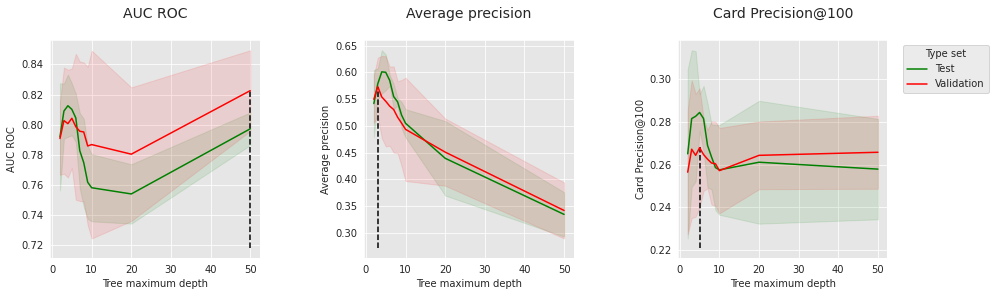

In [27]:
get_performances_plots(performances_df_dt, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       summary_performances=summary_performances_dt)

## 5. Saving the results

The final step is to train the optimized Decision Tree model on the entire training dataset and save it as a deployable artifact.

This process involves:

- Identifying the Optimal Hyperparameter: We select the max_depth that yielded the best Card Precision@100 on the test set, as this is the most pragmatic business metric.
- Creating a Final Pipeline: To ensure consistency, we create a pipeline that includes both the data scaler and the final classifier with the optimal max_depth.
- Training the Model: The pipeline is trained on the full training dataset (train_df) to learn from all available data.
- Saving the Artifact: The entire trained pipeline is saved to a .pkl file using pickle. This single file can be loaded in a production environment to make predictions on new data.

In [42]:
optimal_depth = summary_performances_dt.loc['Optimal parameters', 'Card Precision@100']
print(f"Selected optimal max_depth based on Card Precision@100: {optimal_depth}")

# --- Step 2: Create the Final Model Pipeline ---
# The validation process used a StandardScaler, so we create a final pipeline
# to ensure the same scaling is applied in production. This bundles the
# full model logic (scaling + classification) into one object.
    
final_classifier = sklearn.tree.DecisionTreeClassifier(
    max_depth=optimal_depth,
    random_state=0
)

final_model_pipeline = sklearn.pipeline.Pipeline(steps=[
    ('scaler', sklearn.preprocessing.StandardScaler()),
    ('clf', final_classifier)
])

# --- Step 3: Train the Final Model on the Full Training Set ---
# The final model is trained on the entire 'train_df' to learn from all
# available training data before deployment.
    
X_train = train_df[input_features]
y_train = train_df[output_feature]

print("Training the final model with optimal parameters...")
final_model_pipeline.fit(X_train, y_train)
print("Final model training complete.")

# --- Step 4: Save the Model Artifact ---
# The trained pipeline is saved to a pickle file. This file can be loaded
# in a production environment to make predictions on new data.

# We also get predictions before saving to use in the verification step below
X_test = test_df[input_features]
predictions_before_saving = final_model_pipeline.predict_proba(X_test)[:, 1]
   
with open('final_decision_tree_model.pkl', 'wb') as f:
    pickle.dump(final_model_pipeline, f)

print("Final optimized Decision Tree model saved to 'final_decision_tree_model.pkl'")

Selected optimal max_depth based on Card Precision@100: 5
Training the final model with optimal parameters...
Final model training complete.
Final optimized Decision Tree model saved to 'final_decision_tree_model.pkl'


### Verifying the Saved Model

To ensure the saved model artifact is valid and works as expected, we will load it back into memory and use it to make predictions on the test set. We will then compare these new predictions with the ones generated before the model was saved to confirm they are identical.

In [46]:
with open('final_decision_tree_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    
print("Model 'final_decision_tree_model.pkl' loaded successfully.")

# Make predictions on the test set using the loaded model
predictions_after_loading = loaded_model.predict_proba(X_test)[:, 1]

predictions_df = test_df[['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_FRAUD', 'TX_FRAUD_SCENARIO']].copy()
    
# Add the fraud probabilities predicted by the model
# The 'predictions_before_saving' variable holds these probabilities
predictions_df['FRAUD_PROBABILITY'] = predictions_after_loading
    
# Add a simple 'IS_FRAUD_PREDICTED' column based on a 0.5 threshold
predictions_df['IS_FRAUD_PREDICTED'] = (predictions_df['FRAUD_PROBABILITY'] > 0.5).astype(int)

display(predictions_df)

# Compare the predictions from the model before and after saving
# We use assert_array_almost_equal for safe floating-point comparison
np.testing.assert_array_almost_equal(predictions_before_saving, predictions_after_loading)
    
print("Verification successful: Predictions from the loaded model match the original predictions.")

Model 'final_decision_tree_model.pkl' loaded successfully.


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,FRAUD_PROBABILITY,IS_FRAUD_PREDICTED
134215,1236698,2018-08-08 00:01:14,2765,2747,42.32,0,0.002958,0
134216,1236699,2018-08-08 00:02:33,714,2073,108.19,0,0.002958,0
134218,1236701,2018-08-08 00:08:40,4982,1258,26.13,0,0.002958,0
134219,1236702,2018-08-08 00:08:41,704,8501,65.81,0,0.002958,0
134220,1236703,2018-08-08 00:10:34,3085,4208,55.22,0,0.002958,0
...,...,...,...,...,...,...,...,...
201290,1303773,2018-08-14 23:57:03,460,6133,16.72,0,0.002958,0
201291,1303774,2018-08-14 23:58:24,3101,3229,38.16,0,0.002958,0
201292,1303775,2018-08-14 23:58:24,4783,7511,69.85,0,0.002958,0
201293,1303776,2018-08-14 23:58:45,2883,8550,14.99,0,0.002958,0


Verification successful: Predictions from the loaded model match the original predictions.
